In [71]:
import os, sys, glob
import itertools

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii as at
from astropy.io import fits
import astropy.units as u
from astropy import table
from astropy.table import join,vstack,Table
from astropy.coordinates import SkyCoord

import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=0, vmax=5)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)


from analyze_cluster_output import colors, shapes
from analyze_cluster_output import mass_to_bp_rp, id_solar
from analyze_cluster_output import read_cluster_visual
from plot_periods import plot_periodcolor_histogram

In [2]:
clusters = ["IC_2391","Collinder_135","NGC_2451A","NGC_2547","IC_2602"]
dates = ["2021-06-22","2021-06-18","2021-06-21","2021-06-21","2021-07-02"]

In [19]:
# My crossmatched catalog
per = at.read("tab_all_stars.csv")
# per.dtype

per = Table(per, masked=True, copy=False)

In [20]:
# # Phill's new MINESweeper catalog
# i = 3
# catfile = os.path.expanduser(f"~/Dropbox/data/MINESweeper/catalog_{clusters[i]}_v0.fits")
# # catfile = "catalogs/catalog_NGC_2547_v0.fits"
# with fits.open(catfile) as hdu:
# #     print(hdu.info())
#     cat = Table(hdu[1].data)
# cat.rename_column("GaiaEDR3_ID","GAIAEDR3_ID")
# cat.dtype

In [21]:
catmatch = per #join(cat,per,keys=["GAIAEDR3_ID"],join_type="right")

In [22]:
# mod_file = os.path.expanduser("~/Dropbox/Models/UpSco_Mattea2022/UpSco_Mattea2022_00653Myr.txt")
# mod_file = os.path.expanduser("~/Dropbox/Models/UpSco_Mattea2015/UpSco_Mattea2015_00653Myr.txt")
mod_file = os.path.expanduser("~/Dropbox/Models/UpSco_Mattea2022/UpSco_Mattea2022_00030Myr.txt")
mod = at.read(mod_file,names=["mass","prot"])
mod.dtype

dtype([('mass', '<f8'), ('prot', '<f8')])

In [23]:
catmatch.show_in_notebook()

idx,TIC,GAIAEDR3_ID,GAIAEDR3_RA,GAIAEDR3_DEC,GAIAEDR3_RUWE,GAIAEDR3_G,GAIAEDR3_G_ERR,GAIAEDR3_G_CORRECTED,GAIAEDR3_BP,GAIAEDR3_BP_ERR,GAIAEDR3_RP,GAIAEDR3_RP_ERR,TMASS_ID,TMASS_J,TMASS_J_ERR,TMASS_H,TMASS_H_ERR,TMASS_K,TMASS_K_ERR,HDBscan_MemProb,HDBscan_Cluster,HDBscan_Stability,MemBool,angDist_GES,GES_Target,GES_Cluster,GES_MemProb,angDist_Cantat-Gaudin,CG_MemProb,CG_Cluster,av,av_err,dist,dist_err,log(Age),log(Age)_err,Mass,Mass_err,log(Teff),log(Teff)_err,Prot1,Pw1,Q1,Sig,Prot2,Pw2,Q2,MP?,SE?,LitPeriod,LitSource,Cluster,to_plot
0,44999952,5317681678714511232,129.502,-55.106,1.14,16.079,0.001,16.079,17.939,0.011,14.772,0.002,1.9080660905635139e+18,12.816,0.053,12.225,0.06,11.914,0.039,0.34709173173681357,0.0,0.24671625890317983,1.0,1e+20,N/A,N/A,1e+20,1e+20,1e+20,N/A,0.16916492573952407,0.05407339936792113,153.65096823571244,1.022250092478878,7.395135857329811,0.2730240665643686,0.22891998940473712,0.07289411507778643,3.5431174222131645,0.004020441365396376,0.31,0.25,0.0,0.029,-9999.0,-9999.0,4.0,n,m,--,--,IC_2391,1
1,45050711,5317838088544453760,129.793,-54.603,0.999,16.838,0.001,16.838,18.694,0.027,15.545,0.005,1.926045304700938e+18,13.643,0.044,12.996,0.045,12.785,0.037,0.6346958157365441,0.0,0.24671625890317983,1.0,1e+20,N/A,N/A,1e+20,0.006183,1.0,IC_2391,0.18411269443448802,0.05305368388238709,145.71365839414662,1.0560288854069961,8.140685191060733,0.4969199946322641,0.25194372824606637,0.05240439966725948,3.5454432260794433,0.003118938897413515,0.78,0.161,0.0,0.028,-9999.0,-9999.0,4.0,n,m,--,--,IC_2391,1
2,45184491,5317797818929671808,130.208,-54.506,1.0,16.296,0.001,16.296,18.088,0.011,15.024,0.002,1.908013314005423e+18,13.18,0.032,12.579,0.035,12.314,0.031,0.4013669541003371,0.0,0.24671625890317983,1.0,1e+20,N/A,N/A,1e+20,1e+20,1e+20,N/A,0.165642982986563,0.0556258048559182,142.1769304543115,0.7208781154543126,8.26979032497061,0.49741639816541766,0.32833679011663586,0.0619424218507891,3.5482073724237533,0.0031231268874961976,0.69,0.132,1.0,0.028,-9999.0,-9999.0,4.0,n,m,--,--,IC_2391,1
3,45402598,5317793214724700928,130.302,-54.641,1.044,16.394,0.001,16.394,18.388,0.011,15.064,0.002,1.9080133140054124e+18,13.024,0.03,12.525,0.038,12.173,0.03,0.6274645898737339,0.0,0.24671625890317983,1.0,1e+20,N/A,N/A,1e+20,0.003232,1.0,IC_2391,0.17835701321066183,0.05079493963279454,143.93031762367562,0.8261352794097088,7.8831247931487995,0.5923054364579435,0.30034034400826126,0.09267440589286226,3.542520437278152,0.004383358760924946,0.65,0.804,0.0,0.028,-9999.0,-9999.0,4.0,n,n,--,--,IC_2391,1
4,45402925,5317797578411509120,130.255,-54.517,0.926,10.333,0.001,10.333,10.646,0.001,9.862,0.001,1.9080133140054234e+18,9.36,0.024,9.11,0.025,9.014,0.021,0.4081336855061056,0.0,0.24671625890317983,1.0,1e+20,N/A,N/A,1e+20,1e+20,1e+20,N/A,0.04574602065583015,0.046756025806781995,143.54155239538994,0.24092221022853255,8.201831922251197,0.4376859281649933,1.060999919464333,0.02369579951961426,3.7953058018414896,0.006165758711102808,1.43,0.584,0.0,0.029,-9999.0,-9999.0,4.0,n,y,--,--,IC_2391,1
5,45404408,5317891964614977792,130.284,-53.979,0.98,16.927,0.001,16.927,18.819,0.022,15.632,0.003,1.9440245188384148e+18,13.693,0.028,13.168,0.028,12.829,0.033,1.0,0.0,0.24671625890317983,1.0,1e+20,N/A,N/A,1e+20,0.003084,1.0,IC_2391,0.17082763377925642,0.052211103601372114,153.15411409478043,1.2043703337897287,8.153468509570654,0.475878255579188,0.2560417472951153,0.05324805909126789,3.545185393471993,0.0030546612773070417,0.76,0.27,0.0,0.028,-9999.0,-9999.0,4.0,n,n,--,--,IC_2391,1
6,45407296,5317776069215504000,130.479,-54.82,1.098,15.915,0.001,15.915,17.84,0.01,14.601,0.002,1.8899989154959094e+18,12.635,0.024,12.088,0.025,11.749,0.021,0.4148956508874223,0.0,0.24671625890317983,1.0,1e+20,N/A,N/A,1e+20,1e+20,1e+20,N/A,0.15972822881739465,0.06101892569278782,143.88021436907042,0.753519116697639,7.990718013543143,0.540621386510012,0.39065453036711784,0.08410729719704375,3.5490039025763216,0.00400896467054696,0.26,0.286,0.0,0.028,-9999.0,-9999.0,4.0,m,m,--,--,I

# First we just have to set up the grid and make the model into a histogram

In [40]:
class SpinModel:
    
    def __init__(self,model,model_age,period_scale):
        mod_file = os.path.expanduser(f"~/Dropbox/Models/UpSco_{model}/UpSco_{model}_{model_age:05d}Myr.txt")
    #     print(mod_file)
        mod = at.read(mod_file,names=["mass","prot"])
        
        self.mass_bins = np.arange(0.025,1.4,0.1)

        self.period_scale = period_scale
        if period_scale=="log":
            self.period_bins = np.logspace(np.log10(0.08),np.log10(40),200)
#             self.period_bins = np.logspace(np.log10(0.08),np.log10(40),10)
        else:
            self.period_bins = np.linspace(0,40,200)
#             self.period_bins = np.linspace(0,40,10)

        # Calculate the histogram
        img_raw, self.xedges, self.yedges = np.histogram2d(mod["mass"],mod["prot"],
                                                           bins=[self.mass_bins,self.period_bins])
        # Transpose the image so we can actually plot it
        # by default this is not normalized
        self.img = img_raw.T
        
        self.mass_array = mod["mass"]
        self.prot_array = mod["prot"]

    def normalize(self):
        # Normalize the histogram if desired
        # calculate dM and dP
        dmass = np.diff(self.mass_bins)
        dper = np.diff(self.period_bins)
        
        # Each mass bin should contain (1/nmass)*(1/dmass) of the probability
        nmass = len(dmass)
        
        img_nomask = np.copy(self.img)
        
        # Multiply by dP, to sum correctly
        img_nomask_dp = img_nomask * dper[:,np.newaxis]
        # Then add up the probability in each mass bin
        sum_over_p = np.sum(img_nomask_dp, axis=0)
        # Then normalize each mass bin
        img_nomask_mnorm1 = img_nomask / sum_over_p
        img_nomask_final = img_nomask_mnorm1 / nmass / dmass

        self.img = img_nomask_final
        
    def add_mask(self):
        img_nomask = np.copy(self.img)
        
        # mask the image so it doesn't show cells outside the model
        # Trying to make an array that reflects the bottom of the period bins
        # to make sure I'm not catching the period limits within a bin
        model_exists = np.ones(np.shape(img_nomask),bool)
        mask = np.zeros(np.shape(img_nomask),bool)
        for i in range(len(self.mass_bins)-1):
            mass_loc = ((self.mass_array>=self.mass_bins[i]) & 
                        (self.mass_array<self.mass_bins[i+1]))
            # Calculate whether there are periods in each individual bins
            for j in range(len(self.period_bins)-1):
                per_loc = ((self.prot_array>=self.period_bins[j]) & 
                           (self.prot_array<self.period_bins[j+1]))
                in_this_bin = np.where(mass_loc & per_loc)[0]
    #             print(mass_bins[i],period_bins[j],in_this_bin)
                if len(in_this_bin)==0:
                    model_exists[j,i] = False
            # Now, for this mass range, define the mask to only exclude bins
            # beyond the range of the model
    #         print(model_exists[:,i])
            mod_min_j = min(np.where(model_exists[:,i]==True)[0])
            mod_max_j = max(np.where(model_exists[:,i]==True)[0])
            mask[:mod_min_j,i] = True
            mask[mod_max_j+1:,i] = True

        self.img = np.ma.masked_array(img_nomask,mask=mask)
        self.mask = mask
        
    def plot_hist(self,ax=None):
        if ax is None:
            plt.figure()
            ax = plt.subplot(111)

        X, Y = np.meshgrid(self.xedges, self.yedges)
        ax.pcolormesh(X, Y, self.img,cmap="viridis_r")
    #     ax.plot(mod["mass"],mod["prot"],'k.',alpha=0.25)
        ax.set_yscale(self.period_scale)
        ax.set_xlim(0.025,1.325)
        ax.set_ylim(min(self.period_bins),max(self.period_bins))
        ax.set_xlabel("Mass [Msun]")
        ax.set_ylabel("Period [d]")

(0.07, 18.0)

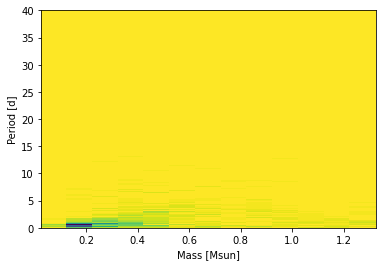

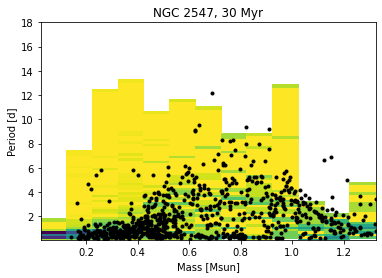

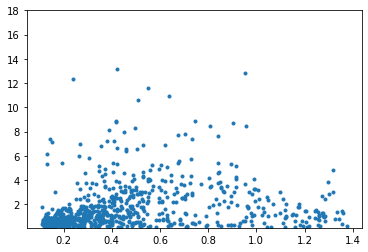

In [44]:
sm = SpinModel("Mattea2022",30,"linear")
sm.plot_hist()
sm.normalize()
sm.add_mask()
sm.plot_hist()
plt.plot(catmatch["Mass"],catmatch["Prot1"],"k.")
plt.ylim(0.07,18)
plt.title("NGC 2547, 30 Myr")

plt.figure()
plt.plot(sm.mass_array,sm.prot_array,'.')
plt.yscale("linear")
plt.ylim(0.07,18)

In [49]:
def plot_model_histogram(model,model_age,period_scale,ax=None,normalize=False):
    mod_file = os.path.expanduser(f"~/Dropbox/Models/UpSco_{model}/UpSco_{model}_{model_age:05d}Myr.txt")
#     print(mod_file)
    mod = at.read(mod_file,names=["mass","prot"])
    sm = SpinModel(model,model_age,period_scale)
    
    period_bins = np.copy(sm.period_bins)
    mass_bins = np.copy(sm.mass_bins)
   
    assert np.all(sm.period_bins==period_bins), "period bin mismatch"
    assert np.all(sm.mass_bins==mass_bins), "mass bin mismatch"

    # Calculate the histogram
    img_raw, xedges, yedges = np.histogram2d(mod["mass"],mod["prot"],
                                         bins=[mass_bins,period_bins])#,density=True)
    # Transpose the image so we can actually plot it
    img_nomask = img_raw.T
    
    assert np.all(img_nomask==sm.img), "image mismatch"
    assert np.all(sm.xedges==xedges), "x mismatch"
    assert np.all(sm.yedges==yedges), "x mismatch"
    
    # Normalize the histogram if desired
    # Angie pointed out that there should be equal weight in each mass bin
    if normalize:
#         print(np.shape(img_nomask))
        dmass = np.diff(mass_bins)
        nmass = len(dmass)
#         print(nmass,"mass bins", 1/nmass)
#         print(np.sum(dmass/nmass))
        dper = np.diff(period_bins)
#         print(len(dper),"period bins")
        
        ### each mass bin should contain 1/nmass of the total probability
        # Multiply each model bin value by dP
        # (for linear period bins dP is the same everywhere, but it won't be for log bins)
        img_nomask_dp = img_nomask * dper[:,np.newaxis]
        # Then add up the probability in each mass bin
        sum_over_p = np.sum(img_nomask_dp, axis=0)
#         print(len(sum_over_p),sum_over_p,"before")
        # Dividing each bin by its sum over dP makes each bin sum to 1 (times dP)
        img_nomask_mnorm1 = img_nomask / sum_over_p
#         print(np.sum(img_nomask_mnorm1 * dper[:,np.newaxis],axis=0),"mid")
        img_nomask_mnorm = img_nomask_mnorm1 / nmass / dmass
        # Now multiply by dM, and normalize in that direction
        sum_over_p = np.sum(img_nomask_mnorm * dper[:,np.newaxis], axis=0)
#         print(sum_over_p,"after")
#         print(np.sum(sum_over_p*dmass), "final")

        ### Testing sums
        print(dmass)
        print(dper)
        dMdP = dmass * dper[:,np.newaxis]
#         print(dMdP[0,0],dmass[0],dper[0])
    
        assert np.sum(img_nomask_mnorm * dMdP)==1, "image does not sum to 1"
        
        img_nomask_final = img_nomask_mnorm

        sm.normalize()

    else:
        img_nomask_final = img_nomask
#     print("nomask_final max",np.max(img_nomask_final))
#     print("nomask_final sum",np.sum(img_nomask_final))
#     print("nomask_final dMdP sum",np.sum(img_nomask_final * dMdP))
#     print(sm.img)
    assert np.all(img_nomask_final==sm.img), "normalized image mismatch"

    
    # mask the image so it doesn't show cells outside the model
    # Trying to make an array that reflects the bottom of the period bins
    # to make sure I'm not catching the period limits within a bin

    model_exists = np.ones(np.shape(img_nomask_final),bool)
    mask = np.zeros(np.shape(img_nomask_final),bool)
    for i in range(len(mass_bins)-1):
        mass_loc = (mod["mass"]>=mass_bins[i]) & (mod["mass"]<mass_bins[i+1])
        # Calculate whether there are periods in each individual bins
        for j in range(len(period_bins)-1):
            per_loc = (mod["prot"]>=period_bins[j]) & (mod["prot"]<period_bins[j+1])
            in_this_bin = np.where(mass_loc & per_loc)[0]
#             print(mass_bins[i],period_bins[j],in_this_bin)
            if len(in_this_bin)==0:
                model_exists[j,i] = False
        # Now, for this mass range, define the mask to only exclude bins
        # beyond the range of the model
#         print(model_exists[:,i])
        mod_min_j = min(np.where(model_exists[:,i]==True)[0])
        mod_max_j = max(np.where(model_exists[:,i]==True)[0])
#         print(mass_bins[i],mod_min_j,mod_max_j)
        mask[:mod_min_j,i] = True
        mask[mod_max_j+1:,i] = True
        
    sm.add_mask()
        
    img = np.ma.masked_array(img_nomask_final,mask=mask)
    assert np.all(img==sm.img), "masked image mismatch"
    
    print(sm.img)

In [50]:
plot_model_histogram("Mattea2022",30,"linear",normalize=True)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503 0.20100503
 0.20100

# Calculating tau-squared

In [51]:
angie = at.read("testing_tausq/mockCluster.txt",header_start=0,data_start=1)
print(angie)

period mass xbin ybin  rho   (1-F)/A    rho'     tau2_i 
------ ---- ---- ---- ------ -------- -------- ---------
  20.0  0.5    4    1    0.0 0.005769 0.005769 10.310433
  15.0  0.6    5    1 0.0115 0.005769 0.013819  8.563388
   2.0  1.3   12    0 0.0577 0.005769 0.046159  6.151317
   1.0  0.8    7    0 0.0462 0.005769 0.038109  6.534597


In [52]:
mod_file = "testing_tausq/3x13Bins.txt"
mod = np.loadtxt(mod_file)
img = mod

mass_bins = np.arange(0.05,1.45,0.1)
period_bins = np.linspace(0,40,4)

print(mass_bins)
print(period_bins)

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35]
[ 0.         13.33333333 26.66666667 40.        ]


In [53]:
def calc_tausq_mock():
    # area of the region containing the model
    A_pm = (np.max(mass_bins)-np.min(mass_bins)) * (np.max(period_bins)-np.min(period_bins))
    # print(A_pm,1/A_pm)

    # model weight? value from section 5.2.3
    fscript = 0.7

    # background term in the tau squared sum
    bkgd_i = (1-fscript)/A_pm
    print("fscript:", fscript, "1 floor value:",bkgd_i)
    
    nprot = len(angie)
    print(nprot)
    sum_rho_prime = 0
    sum_tau_sq = 0
    found_count = 0
    for j in range(len(period_bins)-1):
        in_p_bin = (angie["period"]>period_bins[j]) & (angie["period"]<=period_bins[j+1])
        for i in range(len(mass_bins)-1):
            if img[j,i]<=0:
                # No model at this index; move on
                continue
            else:
                in_m_bin = (angie["mass"]>mass_bins[i]) & (angie["mass"]<=mass_bins[i+1])
                observed = in_p_bin & in_m_bin
                n_in_bin = len(np.where(observed)[0])
                if n_in_bin>0:
                    found_count += n_in_bin
                    this_rho_f = fscript * img[j,i]
                    print("\n",j, i, sm.img[j,i])
                    print("N",n_in_bin,"rho:",img[j,i],"rho prime:",this_rho_f+bkgd_i)
                    sum_rho_prime += (this_rho_f + bkgd_i)*n_in_bin
                    print("tau squared:",-2*np.log((this_rho_f + bkgd_i)*n_in_bin))
                    sum_tau_sq += -2*np.log(this_rho_f)    
    n_missed = nprot - found_count
    bkgd_sum = (-2*np.log(bkgd_i))*n_missed
    sum_tau_sq += bkgd_sum
    
    print("\n",n_missed, bkgd_i)
    sum_rho_prime += (bkgd_i * n_missed)
    tau_sq = -2*np.log(sum_rho_prime)
    
#     print(model_year,model_age,period_scale,tau_sq)
    
    return tau_sq, sum_tau_sq

In [54]:
print(-2*np.log(np.sum(angie["rho'"])))
print(np.sum(angie["tau2_i"]))

4.529499909382048
31.559734999999996


In [55]:
sts = calc_tausq_mock()
print("\n",sts)

fscript: 0.7 1 floor value: 0.005769230769230769
4

 0 7 --
N 1 rho: 0.0462 rho prime: 0.03810923076923076
tau squared: 6.534597497572563

 0 12 --
N 1 rho: 0.0577 rho prime: 0.046159230769230765
tau squared: 6.151316642731774

 1 5 0.15945512820512805
N 1 rho: 0.0115 rho prime: 0.013819230769230768
tau squared: 8.563388245768293

 1 0.005769230769230769

 (4.529482133368705, 33.23584636939804)


# Test a loop

In [56]:
def calc_tausq(model_year,model_age,period_scale):
    sm = SpinModel(model_year,model_age,period_scale)
    sm.normalize()
    sm.add_mask()
    
    # area of the region containing the model
    A_pm = (np.max(sm.mass_bins)-np.min(sm.mass_bins)) * (np.max(sm.period_bins)-np.min(sm.period_bins))
    # print(A_pm,1/A_pm)

    # model weight? value from section 5.2.3
    fscript = 0.7

    # background term in the tau squared sum
    bkgd_i = (1-fscript)/A_pm
#     print("fscript:", fscript, "1 floor value:",bkgd_i)
    
    use = ((catmatch["Mass"]<max(sm.mass_bins)) & 
           (catmatch["Mass"]>=min(sm.mass_bins)) & 
           (catmatch["Mass"].mask==False) & 
           (catmatch["Prot1"]>0))
    
    nprot = len(np.where(use)[0])
#     print(nprot)
    sum_rho = 0
    sum_rho_prime = 0
    sum_tau_sq = 0
    found_count = 0
    for j in range(len(sm.period_bins)-1):
        in_p_bin = (catmatch["Prot1"]>sm.period_bins[j]) & (catmatch["Prot1"]<=sm.period_bins[j+1])
        for i in range(len(sm.mass_bins)-1):
            if sm.mask[j,i]==True:
                # No model at this index; move on
                continue
            else:
                in_m_bin = (catmatch["Mass"]>sm.mass_bins[i]) & (catmatch["Mass"]<=sm.mass_bins[i+1])
                observed = use & in_p_bin & in_m_bin
                n_in_bin = len(np.where(observed)[0])
                if n_in_bin>0:
                    found_count += n_in_bin
                    this_rho_f = fscript * sm.img[j,i]
                    this_rho_prime = this_rho_f + bkgd_i
#                     print("\n",j, i, sm.img[j,i])
#                     print("N",n_in_bin,"rho:",sm.img[j,i],"rho prime:",this_rho_prime)
                    sum_rho_prime += (this_rho_prime * n_in_bin)
#                     print("tau squared:",-2*np.log(this_rho + bkgd_i*n_in_bin))
                    sum_tau_sq += np.log(this_rho_prime)*n_in_bin

    n_missed = nprot - found_count
    sum_rho += (bkgd_i * n_missed)
    
    tau_sq = -2 * np.log(sum_rho_prime)
#     print("tau2:",tau_sq)
    
    bkgd_sum = (np.log(bkgd_i)*n_missed)
    sum_tau_sq += bkgd_sum
    sum_tau_sq = -2*sum_tau_sq
    
#     print(model_year,model_age,period_scale,tau_sq)
    
    return tau_sq, sum_tau_sq

In [58]:
model, age, period_scale = "Mattea2022", 30, "linear"
ts1, ts2 = calc_tausq(model,age,period_scale)

Mattea2015
Mattea2022
ZeroTorque


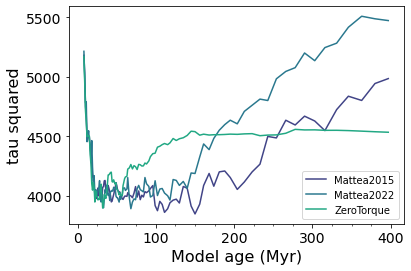

In [81]:
# Find all the model ages I have
# model_year = 2022

model_names = ["Mattea2015","Mattea2022","ZeroTorque"]
period_scale = "linear"

plt.figure()
for j,model in enumerate(model_names):
    print(model)
    models = glob.glob(os.path.expanduser(f"~/Dropbox/Models/UpSco_{model}/UpSco_{model}*Myr.txt"))
    # print(models)

    model_ages = np.sort([int(mod.split("_")[-1][:5]) for mod in models])
    # print(model_ages)
    
    model_ages = model_ages[model_ages<=400]
    
    all_tau_sq = np.zeros(len(model_ages))
    all_tau_sq_old = np.zeros(len(model_ages))
    for i, age in enumerate(model_ages):
    #     print("\n",age)
        all_tau_sq_old[i], all_tau_sq[i] = calc_tausq(model,age,period_scale)

    plt.plot(model_ages,all_tau_sq,'-',label=model,color=mapper.to_rgba(j+1))
    plt.legend(loc=4)
    plt.xlabel("Model age (Myr)",fontsize=16)
    plt.ylabel("tau squared",fontsize=16)
#     plt.title(model,fontsize=14)
    
    ax = plt.gca()
    ax.tick_params(labelsize=14)
    ax.set_xticks(np.arange(0,400,25),minor=True)
plt.savefig(f"plots/tausq_ZAMS.png",bbox_inches="tight",dpi=600)

In [85]:
# Find all the model ages I have
# model_year = 2022

model_names = ["Mattea2015","Mattea2022","ZeroTorque"]
period_scale = "linear"

plt.figure()
for j,model in enumerate(model_names):
    print(model)
    models = glob.glob(os.path.expanduser(f"~/Dropbox/Models/UpSco_{model}/UpSco_{model}*Myr.txt"))
    
    model_ages = np.sort([int(mod.split("_")[-1][:5]) for mod in models])
    # print(model_ages)
    
    model_ages = model_ages[(model_ages<=400) & (model_ages>=0)]
    
    for i, age in enumerate(model_ages):
    #     print("\n",age)
    
        tau_sq_old, tau_sq = calc_tausq(model,age,period_scale)
        sm = SpinModel(model,age,period_scale)
        sm.normalize()
        sm.add_mask()
        sm.plot_hist()
        plt.plot(catmatch["Mass"],catmatch["Prot1"],"k.",ms=2,alpha=0.5)
        plt.ylim(0.07,18)
        plt.xlim(1.3,0.1)
        plt.title(f"{age:03d} Myr: tau2={tau_sq:.0f}")
        plt.savefig(f"plots/tausq_{model}_{age}Myr_{period_scale}_ZAMS.png",bbox_inches="tight",dpi=600)
        plt.close()

Mattea2015
Mattea2022
ZeroTorque


<Figure size 432x288 with 0 Axes>

# Try with praesepe

In [37]:
prae = at.read("catalogs/rampalli_apjac0c1et4_mrt.txt")

In [38]:
def calc_tausq_praesepe(model_year,model_age,period_scale):
    sm = SpinModel(model_year,model_age,period_scale)
    sm.normalize()
    sm.add_mask()
    
    # area of the region containing the model
    A_pm = (np.max(sm.mass_bins)-np.min(sm.mass_bins)) * (np.max(sm.period_bins)-np.min(sm.period_bins))
    # print(A_pm,1/A_pm)

    # model weight? value from section 5.2.3
    fscript = 0.7

    # background term in the tau squared sum
    bkgd_i = (1-fscript)/A_pm
    
    use = ((prae["Mass"]<max(sm.mass_bins)) & 
           (prae["Mass"]>=min(sm.mass_bins)) & 
           (prae["Mass"].mask==False) & 
           (prae["Prot"]>0) & 
           (prae["QFClean"]==1))
    
    nprot = len(np.where(use)[0])
#     print(nprot)
    sum_rho = 0
    sum_rho_prime = 0
    sum_tau_sq = 0
    found_count = 0
    for j in range(len(sm.period_bins)-1):
        in_p_bin = (prae["Prot"]>sm.period_bins[j]) & (prae["Prot"]<=sm.period_bins[j+1])
        for i in range(len(sm.mass_bins)-1):
            if sm.mask[j,i]==True:
                # No model at this index; move on
                continue
            else:
                in_m_bin = (prae["Mass"]>sm.mass_bins[i]) & (prae["Mass"]<=sm.mass_bins[i+1])
                observed = use & in_p_bin & in_m_bin
                n_in_bin = len(np.where(observed)[0])
                if n_in_bin>0:
                    found_count += n_in_bin
                    this_rho_f = fscript * sm.img[j,i]
                    this_rho_prime = this_rho_f + bkgd_i
#                     print("\n",j, i, sm.img[j,i])
#                     print("N",n_in_bin,"rho:",sm.img[j,i],"rho prime:",this_rho_prime)
                    sum_rho_prime += (this_rho_prime * n_in_bin)
#                     print("tau squared:",-2*np.log(this_rho + bkgd_i*n_in_bin))
                    sum_tau_sq += np.log(this_rho_prime)*n_in_bin

    n_missed = nprot - found_count
    sum_rho += (bkgd_i * n_missed)
    
    tau_sq = -2 * np.log(sum_rho_prime)
#     print("tau2:",tau_sq)
    
    bkgd_sum = (np.log(bkgd_i)*n_missed)
    sum_tau_sq += bkgd_sum
    sum_tau_sq = -2*sum_tau_sq
#     print("tau2 alt:",sum_tau_sq)

    #     print(model_year,model_age,period_scale,tau_sq)
    
    return tau_sq, sum_tau_sq

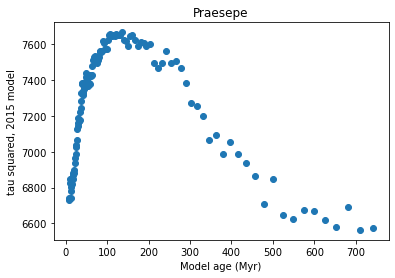

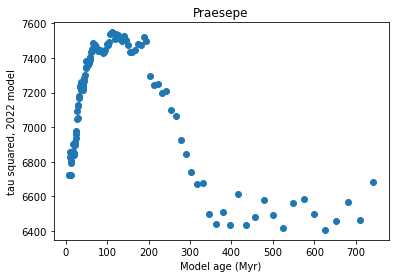

In [39]:
for model_year in [2015,2022]:
    p_tau_sq = np.zeros(len(model_ages))
    p_tau_sq2 = np.zeros(len(model_ages))
    for i, age in enumerate(model_ages):
    #     if age<600:
    #         continue
        p_tau_sq[i], p_tau_sq2[i] = calc_tausq_praesepe(model_year,age,period_scale)
    plt.figure()
    plt.plot(model_ages,p_tau_sq2,'o')
    plt.xlabel("Model age (Myr)")
    plt.ylabel(f"tau squared, {model_year} model")
    plt.title("Praesepe")